# RNN 기반 추천모델 성능 개선 예제
## : 세션 정의에 따른 성능 개선 여부 확인

#### 초록
***
<span style="font-size:11pt; line-height:1.8;">
    &nbsp; &nbsp; 'The MovieLens(2015)' 데이터셋을 이용하여 'UserId'와 'Time'을 토대로 세션을 1분, 30분 1시간으로 새롭게 정의하여 각 모델을 생성 하고 평가하였다. 'The MovieLens(2015)' 데이터셋은 총 1,000,209개 레코드로 2000년 4월 25일부터 2003년 2월 28일까지의 데이터 이며, 'UserId', 'ItemId', 'Rating', 'Time'으로 이루어져 있다. 또한 각 세션 별로 분석한 결과, 1분 단위 세션의 경우 총 284,962개로 98%의 세션이 11개의 레코드, 30분 단위 세션의 경우 총 39,221개로 98%의 세션이 141개의 레코드, 1시간 단위 세션의 경우 총 31,969개로 98%의 세션이 199개의 레코드를 가진다. 또한, 데이터의 가장 최근에 해당하는 2003년 2월 28일 기준 특정 기간 이전까지의 데이터 수를 확인한 결과, 2년 이전 데이터는 총 69,349개이다. 이를 통해 데이터 전처리를 실시 하였으며, '세션 길이 중심 전처리', '세션 시간 중심 전처리', '평점 중심 전처리', '데이터 분할', '데이터 인덱싱' 순으로 진행하였다. 모델은 SESSION-BASED RECOMMENDATIONS WITH RECURRENT NEURAL NETWORKS(2016) 기반의 RNN 모델을 생성하고
각 지표로 Recall과 MRR을 채택하였고 모든 모델은 배치 사이즈 64, 학습률 0.001, epoch 10회로 설정하여 학습하였다. 그 결과 각 모델의 테스트 데이터에 대한 성능은, '1분 기준 세션 모델'의 경우 Recall이 0.080, MRR이 0.023이었으며, '30분 기준 세션 모델'의 경우 Recall이 0.099, MRR이 0.029, '1시간 기준 세션 모델'은 Recall이 0.092, MRR이 0.024로 '30분', '1시간' '1분' 순으로 세션을 정의하였을 때, 성능이 높은 것을 확인하였다.
</span>

***

<br>

## 1. 서론
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 본 예제에서는 'The MovieLens(2015)' 데이터셋을 사용하여 RNN 기반의 추천모델을 생성하고 이를 학습 및 평가합니다. 특히, 유저의 ID와 평가가 이루어진 시간을 바탕으로 세션을 새롭게 정의하여 세션에 따른 모델을 생성, 평가 합니다. 세션은 '1분', '30분', '1시간' 단위로 정의하여 이에대한 비교를 진행합니다. 다음은 본 예제의 진행 순서에 해당합니다.
</span><br><br>


> _1. 데이터 분석_
>
> _2. 세션 정의_
>
> _3. 세션 중심 데이터 분석_
>
> _4. 데이터 전처리_
>
> _5. 모델 생성_
>
> _6. 모델 학습 및 평가_

***

<br>

## 2. 데이터 분석
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 'The MovieLens(2015)' 데이터셋의 기본적인 사항을 파악합니다. 속성은 유저와 영화를 구분하는 정수로 된 `UserId`, `ItemId`,
영화에 대한 평가인 1에서 5사이의 정수 `Rating`, 평가가 이루어진 시간이 Unix Time 형식의 `Time`으로 이루어져 있습니다. 데이터 레코드는 총 1,000,209개이며 결측치는 없고 고유한 `UserId`는 6,040개, `ItemId`는 총 3,706개입니다. 데이터는 2000년 4월 25일부터 2003년 2월 28일 동안의 데이터 입니다. 또한, 유저별 평균 약 165회 영화 평가를 실시하였으며, 평가 주기는 평균 약 25일 입니다. &lt;Fig. 1>은 일단위 유저별 평가주기를 시각화 한 것입니다.
</span>

***

#### 필요 라이브러리 호출
***
+ 예제에 사용할 라이브러리를 호출 합니다.
***

In [1]:
import os   #디렉토리 관리
import matplotlib.pyplot as plt   #데이터 시각화

import time   #timestamp => time
from datetime import datetime   #timestamp => time
from datetime import timedelta   #시간 연산


import numpy as np   #행렬 연산
import pandas as pd   #데이터프레임 관리
pd.options.display.float_format = '{:.3f}'.format   #소숫점 세자리 출력


#모델 설게==========================
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
#End================================


import warnings   #경고
warnings.filterwarnings('ignore')   #경고 무시

<br>

#### 데이터셋 불러오기
***
+ 예제에 사용할 데이터셋을 불러옵니다.
***

In [2]:
#데이터셋 불러오기========================================
dataset_path = "./dataset/yoochoose/data/ratings.dat"

data = pd.read_csv(
    dataset_path, sep='::', header=None,
    usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32},
    nrows=None, engine="python"
)

data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
data.sort_values(['UserId', 'Time'], inplace=True)
#End======================================================


#출력부===================================================
analy_data = data.copy()
analy_data.head(5)
#End======================================================

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103


#### 데이터셋 정보
***
F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History
and Context. ACM Transactions on Interactive Intelligent Systems (TiiS) 5, 4,
Article 19 (December 2015), 19 pages. DOI=http://dx.doi.org/10.1145/2827872
***

<br>

#### 데이터 기본 정보
***
+ 총 1,000,209개의 데이터와 결측치는 없으며 `User`는 총 6,040명, `Item`은 총 3,706개의 데이터가 있습니다.
***

In [3]:
analy_data.info()

print("\n" + "*" * 50)
print("User unique num:", analy_data["UserId"].nunique())
print("Item unique num:", analy_data["ItemId"].nunique())
print("*" * 50)

analy_data.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000209 entries, 31 to 1000042
Data columns (total 4 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   UserId  1000209 non-null  int32
 1   ItemId  1000209 non-null  int32
 2   Rating  1000209 non-null  int32
 3   Time    1000209 non-null  int64
dtypes: int32(3), int64(1)
memory usage: 26.7 MB

**************************************************
User unique num: 6040
Item unique num: 3706
**************************************************


,UserId,ItemId,Rating,Time
count,1000209.000,1000209.000,1000209.000,1000209.000
mean,3024.512,1865.540,3.582,972243695.405
std,1728.413,1096.041,1.117,12152558.940
min,1.000,1.000,1.000,956703932.000
25%,1506.000,1030.000,3.000,965302637.000
50%,3070.000,1835.000,4.000,973018006.000
75%,4476.000,2770.000,4.000,975220939.000
max,6040.000,3952.000,5.000,1046454590.000


<br>

#### Unix 타임 변환
***
+ Unix 타임으로 되어있는 `Time`의 데이터를 datetime 형식으로 바꾼 후, 정렬하여 줍니다.


+ 2000년 4월 25일부터 2003년 2월 28일까지의 데이터가 존재합니다.
***

In [4]:
analy_data["Time_h"] = analy_data["Time"].apply(lambda x: datetime.fromtimestamp(x))

analy_data.sort_values("Time_h")

,UserId,ItemId,Rating,Time,Time_h
1000138,6040,858,4,956703932,2000-04-25 23:05:32
999873,6040,593,5,956703954,2000-04-25 23:05:54
1000153,6040,2384,4,956703954,2000-04-25 23:05:54
1000007,6040,1961,4,956703977,2000-04-25 23:06:17
1000192,6040,2019,5,956703977,2000-04-25 23:06:17
...,...,...,...,...,...
825793,4958,2399,1,1046454338,2003-02-28 17:45:38
825438,4958,1407,5,1046454443,2003-02-28 17:47:23
825724,4958,3264,4,1046454548,2003-02-28 17:49:08
825731,4958,2634,3,1046454548,2003-02-28 17:49:08


<br>

#### 유저별 평가 횟수
***
+ 유저별 평균 약 165회 영화에 대한 평가가 이루어 졌습니다.


+ 75% 유저는 약 208회 평가를 실시 하였습니다.


+ 가장 많은 평가를 한 유저는 2,314회 실시 하였습니다.
***

In [5]:
print("*" * 50)
print(analy_data.groupby("UserId").size().describe())
print("*" * 50)

**************************************************
count   6040.000
mean     165.598
std      192.747
min       20.000
25%       44.000
50%       96.000
75%      208.000
max     2314.000
dtype: float64
**************************************************


<br>

#### 유저별 평가 간격
***
+ 평균 약 25일 간격으로 영화를 평가 합니다.


+ 75%의 유저는 약 5.5일 간격으로 영화를 평가 합니다.


+ 평가 간격이 가장 긴 유저는 약 1년 4개월 입니다.
***

**************************************************
count       6040.000
mean     2158428.273
std      5466795.946
min           39.724
25%          349.795
50%         1107.985
75%       475082.376
max     43070685.021
Name: Time, dtype: float64
**************************************************


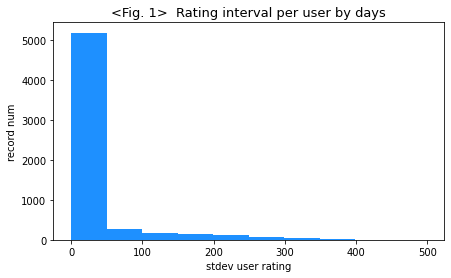

In [6]:
#유저별 평가 간격
test = analy_data.groupby("UserId")["Time"].std().reset_index()

print("*" * 50)
print(test["Time"].describe())
print("*" * 50)

plt.figure(figsize=(7, 4))
plt.title("<Fig. 1>  Rating interval per user by days", size= 13)
plt.hist(test["Time"]/60/60/24, bins=10, color="#1e90ff")
plt.ylabel("record num")
plt.xlabel("stdev user rating")
plt.show()

<br>

## 3. 세션 정의
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 'UserId'와 'Time' 데이터를 바탕으로 새롭게 세션을 정의하고 이를 토대로 추천 모델을 생성하고자 합니다. 'UserId'만을 이용할 경우, 시간에 따른 트랜드를 반영할 수 없습니다. 따라서, 'Time' 데이터를 이용하여 'UserId'와 결합하여 이를 해결하고자 합니다. 평가가 이루어진 시간에 해당하는 'Time'을 1분, 30분, 1시간 간격으로 묶어 'UserId'-'Time'의 세션을 정의 합니다. &lt;Fig. 2>는 세션 정의 방법을 도식화 한 것입니다. ①의 과정에서 'Time'을 1분, 30분, 60분 단위로 통합하여 줍니다. ②의 과정에서 각 단위로 통합된 데이터를 'UserId'와 결합하여 줍니다. 최종적으로 이를 세션으로 사용합니다.
</span><br><br>

<img src="./img/fig1.png" width=900></img>

&lt;Fig. 2> 세션 정의 순서
***

### 3.1. 1분 단위 세션 정의
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 1분 단위로 세션을 정의 합니다. 동시, 동분을 하나로 통합하는 것으로, 22시 15분 5초와 22시 15분 45초를 22시 15분 0초로 통합하여 동일한 세션으로 보는 것입니다. 이러한 개념을 바탕으로 'Time'을 재정의 한 후, 'UserId'와 합친 후, 이를 다시 순차적으로 인덱싱 합니다.
</span>

***

#### `Time` 데이터 1분 단위로 변환
***
+ 초 단위의 `Time` 데이터에서 '초(sec)' 영역을 제외하여 줍니다.


+ `Time` 속성 Index 31의 데이터 978300019(2000-12-31 22:0:19)의 초에 해당하는 값 19가 `Time_1min`에서 0으로 변환된 것을 확인할 수 있습니다.
***

In [7]:
session_1min = data.copy()

def cut_1min(x):
    date_ = datetime.fromtimestamp(x)
    date_ = date_ - timedelta(seconds=date_.second)
    return int(time.mktime(date_.timetuple()))

session_1min["Time_1min"] = session_1min["Time"].apply(cut_1min)   #초단위 제외


session_1min.head(5)

,UserId,ItemId,Rating,Time,Time_1min
31,1,3186,4,978300019,978300000
22,1,1270,5,978300055,978300000
27,1,1721,4,978300055,978300000
37,1,1022,5,978300055,978300000
24,1,2340,3,978300103,978300060


<br>

#### `UserId` 및 `Time` 중복 레코드 통합
***
+ `UserId`와 `Time`에 대한 중복 레코드를 통합 합니다.


+ `Time_1min`의 평균은 하나의 값으로 통일 되어 있기 때문에 결국 동일한 값에 해당 합니다.
***

In [8]:
session_1min = session_1min.groupby(["UserId", "Time"])["Time_1min"].mean().reset_index()
session_1min

,UserId,Time,Time_1min
0,1,978300019,978300000
1,1,978300055,978300000
2,1,978300103,978300060
3,1,978300172,978300120
4,1,978300275,978300240
...,...,...,...
471158,6040,997454398,997454340
471159,6040,997454429,997454400
471160,6040,997454464,997454460
471161,6040,997454486,997454460


<br>

#### `UserId` 와 `Time_1min` 문자열 합치기
***
+ `UserId`와 `Time_1min`의 값을 문자열로 합친 후 다시 정수로 변환합니다.


+ `comb_user_time`의 값이 최종 세션이 됩니다.
***

In [9]:
comb_user_time = session_1min.loc[:, ["UserId", "Time_1min"]].copy()
comb_user_time = comb_user_time.astype({"UserId": str, "Time_1min": str})   #문자열로 변환

comb_user_time = comb_user_time["UserId"] + comb_user_time["Time_1min"]
comb_user_time = comb_user_time.astype(int)

session_1min["comb_user_time"] = comb_user_time
session_1min

,UserId,Time,Time_1min,comb_user_time
0,1,978300019,978300000,1978300000
1,1,978300055,978300000,1978300000
2,1,978300103,978300060,1978300060
3,1,978300172,978300120,1978300120
4,1,978300275,978300240,1978300240
...,...,...,...,...
471158,6040,997454398,997454340,6040997454340
471159,6040,997454429,997454400,6040997454400
471160,6040,997454464,997454460,6040997454460
471161,6040,997454486,997454460,6040997454460


<br>

#### unique 인덱스로 변환하기
***
+ `comb_user_time` 값을 고유 인덱스 값으로 치환하여 줍니다.
***

In [10]:
session_list = session_1min["comb_user_time"]
unique_list = session_1min["comb_user_time"].unique()
unique_list = [np.where(unique_list == session)[0][0] for session in session_list]

session_1min["Session"] = unique_list


session_1min

,UserId,Time,Time_1min,comb_user_time,Session
0,1,978300019,978300000,1978300000,0
1,1,978300055,978300000,1978300000,0
2,1,978300103,978300060,1978300060,1
3,1,978300172,978300120,1978300120,2
4,1,978300275,978300240,1978300240,3
...,...,...,...,...,...
471158,6040,997454398,997454340,6040997454340,284968
471159,6040,997454429,997454400,6040997454400,284969
471160,6040,997454464,997454460,6040997454460,284970
471161,6040,997454486,997454460,6040997454460,284970


<br>

#### 기존 데이터와 `Session` 결합
***
+ 생성한 1분 단위 세션을 기존 데이터와 결합 합니다.
***

In [11]:
session_1min.drop(columns=["Time_1min", "comb_user_time"], inplace=True)
session_1min_data = pd.merge(data, session_1min, on=["UserId", "Time"])

session_1min_data

,UserId,ItemId,Rating,Time,Session
0,1,3186,4,978300019,0
1,1,1270,5,978300055,0
2,1,1721,4,978300055,0
3,1,1022,5,978300055,0
4,1,2340,3,978300103,1
...,...,...,...,...,...
1000204,6040,2917,4,997454429,284969
1000205,6040,1921,4,997454464,284970
1000206,6040,1784,3,997454464,284970
1000207,6040,161,3,997454486,284970


<br>

#### 과정 통합 함수 생성
***
+ 'UserId 및 Time 중복 레코드 통합', 'UserId 와 Time_1min 문자열 합치기', 'unique 인덱스로 변환하기', '기존 데이터와 Session 결합' 과정을 통합하는 함수를 생성하여 30분, 1시간 단위 세션 정의 시에 사용합니다.
***

In [12]:
def get_session_dataset(session_min_df, session_column):
    #UserId와 Time에 대한 중복 레코드를 통합=======================
    session_min_df = session_min_df.groupby(["UserId", "Time"])[session_column].mean().reset_index()
    #End===========================================================


    #UserId 와 Time_1min 문자열 합치기=============================
    comb_user_time = session_min_df.loc[:, ["UserId", session_column]].copy()
    comb_user_time = comb_user_time.astype({"UserId": str, session_column: str})   #문자열로 변환

    comb_user_time = comb_user_time["UserId"] + comb_user_time[session_column]
    comb_user_time = comb_user_time.astype(int)

    session_min_df["comb_user_time"] = comb_user_time
    #End===========================================================


    #unique 인덱스로 변환하기======================================
    session_list = session_min_df["comb_user_time"]
    unique_list = session_min_df["comb_user_time"].unique()
    unique_list = [np.where(unique_list == session)[0][0] for session in session_list]

    session_min_df["Session"] = unique_list
    #End===========================================================


    #기존 데이터와 Session 결합
    session_min_df.drop(columns=[session_column, "comb_user_time"], inplace=True)
    session_min_df_data = pd.merge(data, session_min_df, on=["UserId", "Time"])
    #End===========================================================

    return session_min_df_data

<br>

### 3.2. 30분 단위 세션 정의
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 30분 단위로 세션을 정의 합니다. 30분 단위로 시간을 통합하는 것으로 30분 단위로 이루어진 평가를 동일한 세션으로 보는 것입니다. 이러한 개념을 바탕으로 'Time'을 재정의 한 후, 'UserId'와 합친 후, 이를 다시 순차적으로 인덱싱 합니다.
</span>

***

#### `Time` 데이터 30분 단위로 변환
***
+ 초 단위의 `Time` 데이터에서 '분(minute)'이 30분 미만의 경우 0분으로, 30분 이상의 경우 30으로 치환 합니다.


+ `Time` 속성 Index 2의 데이터 978301968(2000-12-31 22:32:48)가 `Time_30min`에서 978301800(2000-12-31 22:30:00)으로 변환된 것을 확인할 수 있습니다.
***

In [13]:
session_30min = data.copy()

def cut_30min(x):
    date_ = datetime.fromtimestamp(x)
    date_ = date_ - timedelta(seconds=date_.second)
        
    if int(date_.minute) < 30:
        date_ = date_ - timedelta(minutes=date_.minute)
    else:
        date_ = date_ + timedelta(minutes=30 - date_.minute)
    return int(time.mktime(date_.timetuple()))


session_30min["Time_30min"] = session_30min["Time"].apply(cut_30min)   #초단위 제외


session_30min[25:30]

,UserId,ItemId,Rating,Time,Time_30min
2,1,914,3,978301968,978301800
6,1,1287,5,978302039,978301800
19,1,2797,4,978302039,978301800
38,1,2762,4,978302091,978301800
52,1,1246,4,978302091,978301800


<br>

#### 30분 단위 세션 데이터 획득
***
+ 앞서 생성한 통합 함수를 이용하여 30분 단위 세션 데이터를 획득 합니다.
***

In [14]:
session_30min_data = get_session_dataset(session_30min, "Time_30min")

session_30min_data

,UserId,ItemId,Rating,Time,Session
0,1,3186,4,978300019,0
1,1,1270,5,978300055,0
2,1,1721,4,978300055,0
3,1,1022,5,978300055,0
4,1,2340,3,978300103,0
...,...,...,...,...,...
1000204,6040,2917,4,997454429,39219
1000205,6040,1921,4,997454464,39219
1000206,6040,1784,3,997454464,39219
1000207,6040,161,3,997454486,39219


<br>

### 3.3. 1시간 단위 세션 정의
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 1시간 단위로 세션을 정의 합니다. 1시간 단위로 시간을 통합하는 것으로 1시간 단위로 이루어진 평가를 동일한 세션으로 보는 것입니다. 이러한 개념을 바탕으로 'Time'을 재정의 한 후, 'UserId'와 합친 후, 이를 다시 순차적으로 인덱싱 합니다.
</span>

***

#### `Time` 데이터 1시간 단위로 변환
***
+ 초 단위의 `Time` 데이터에서 '시(hour)'이하 숫자는 0으로 치환 합니다.


+ `Time` 속성 Index 31의 데이터 978300019(2000-12-31 22:00:19)가 `Time_60min`에서 978300000(2000-12-31 22:00:00)으로 변환된 것을 확인할 수 있습니다.
***

In [15]:
session_60min = data.copy()

def cut_60min(x):
    date_ = datetime.fromtimestamp(x)
    date_ = date_ - timedelta(seconds=date_.second, minutes=date_.minute)
    return int(time.mktime(date_.timetuple()))


session_60min["Time_60min"] = session_60min["Time"].apply(cut_60min)   #초단위 제외


session_60min.head(5)

,UserId,ItemId,Rating,Time,Time_60min
31,1,3186,4,978300019,978300000
22,1,1270,5,978300055,978300000
27,1,1721,4,978300055,978300000
37,1,1022,5,978300055,978300000
24,1,2340,3,978300103,978300000


<br>

#### 1시간 단위 세션 데이터 획득
***
+ 앞서 생성한 통합 함수를 이용하여 1시간 단위 세션 데이터를 획득 합니다.
***

In [16]:
session_60min_data = get_session_dataset(session_60min, "Time_60min")

session_60min_data

,UserId,ItemId,Rating,Time,Session
0,1,3186,4,978300019,0
1,1,1270,5,978300055,0
2,1,1721,4,978300055,0
3,1,1022,5,978300055,0
4,1,2340,3,978300103,0
...,...,...,...,...,...
1000204,6040,2917,4,997454429,31967
1000205,6040,1921,4,997454464,31967
1000206,6040,1784,3,997454464,31967
1000207,6040,161,3,997454486,31967


<br>

## 4. 세션 중심 데이터 분석
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 새롭게 정의된 세션을 중심으로 데이터를 분석 합니다. 세션 중심 분석은 세션의 레코드 수를 바탕으로 이루어지는 '세션 길이 중심 분석'과 시간을 중심으로 이루어지는 '세션 시간 중심 분석'으로 이루어집니다. 해당 분석을 바탕으로 데이터 전처리 과정을 진행합니다.
</span>

***

### 4.3. 1분 단위 세션 데이터 분석
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 1분 단위로 정의된 고유 세션은 총 284,962개 이며, 세션별 평균 약 3개의 레코드를 가지고 있습니다. 최대 33개의 레코드를 가진 세션이 존재하며, 75%의 세션은 5개의 레코드를, 98%의 세션은 11개의 레코드를 가지고 있습니다. 또한, 2003년 2월 28일 기준 약 1개월 이전의 데이터는 총 1,551개, 6개월 이전 데이터는 8,823개, 1년 이전 데이터는 21,704개, 2년 이전 데이터는 69,349개 입니다. &lt;Fig. 3>은 1분 단위로 정의된 세션이 가지는 레코드 수에 따른 누적 비율을 시각화 한 것입니다.
</span>

***

#### 세션 길이 중심 분석
***
+ 총 284,972개의 세션이 존재하며, 세션별 평균 약 3개의 레코드를 가지고 있고 75%의 세션이 5개의 레코드를, 최대 33개의 레코드를 가지고 있는 세션이 존재 합니다.


+ 또한, 98%의 세션이 11개의 레코드를 가지고 있습니다.
***

***********************************
count   284972.000
mean         3.510
std          2.738
min          1.000
25%          1.000
50%          3.000
75%          5.000
max         33.000
dtype: float64
***********************************
98% session length 11.0


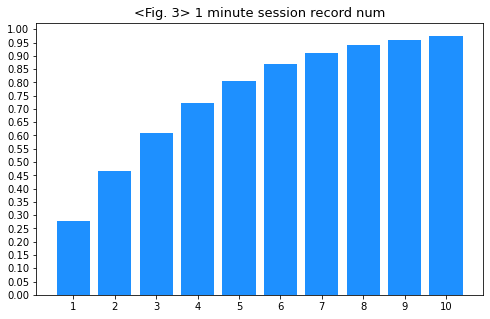

In [17]:
session_length = session_1min_data.groupby("Session").size()

print("*" * 35)
print(session_length.describe())
print("*" * 35)
print("98% session length", session_length.quantile(0.98))

#세션 길이에 따른 분포
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_98 = length_percent_cumsum[length_percent_cumsum < 0.98]


#시각화
plt.figure(figsize=(8, 5))
plt.title('<Fig. 3> 1 minute session record num', size=13)
plt.bar(x=length_percent_cumsum_98.index,
        height=length_percent_cumsum_98, color="#1e90ff")
plt.xticks(length_percent_cumsum_98.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.show()

<br>

#### 세션 시간 중심 분석
***
+ 영화에 대한 평가는 2000년 4월 25일부터 2003년 2월 28일 약 3년 동안 이루어 졌습니다.


+ 2003년 2월 28일 기준 약 1개월 이전의 데이터는 총 1,551개, 6개월 이전 데이터는 8,823개, 1년 이전 데이터는 21,704개, 2년 이전 데이터는 69,349개 입니다.
***

In [18]:
oldest, latest = session_1min_data['Time'].min(), session_1min_data['Time'].max()

month1 = len(session_1min_data[session_1min_data["Time"] > (latest - 30 * 1 * 86400)])
month6 = len(session_1min_data[session_1min_data["Time"] > (latest - 30 * 6 * 86400)])
month12 = len(session_1min_data[session_1min_data["Time"] > (latest - 365 * 1 * 86400)])
month24 = len(session_1min_data[session_1min_data["Time"] > (latest - 365 * 2 * 86400)])


print("data date:", datetime.fromtimestamp(oldest), "~", datetime.fromtimestamp(latest))
print("*" * 35)
print("1 month ago data num:", month1)
print("6 month ago data num:", month6)
print("12 month ago data num:", month12)
print("24 month ago data num:", month24)
print("*" * 35)

data date: 2000-04-25 23:05:32 ~ 2003-02-28 17:49:50
***********************************
1 month ago data num: 1551
6 month ago data num: 8823
12 month ago data num: 21704
24 month ago data num: 69349
***********************************


<br>

### 4.3. 30분 단위 세션 데이터 분석
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 30분 단위로 정의된 고유 세션은 총 39,221개 이며, 세션별 평균 약 25개의 레코드를 가지고 있습니다. 최대 439개의 레코드를 가진 세션이 존재하며, 
75%의 세션은 34개의 레코드를, 98%의 세션은 141개의 레코드를 가지고 있습니다. 
또한, 2003년 2월 28일 기준 약 1개월 이전의 데이터는 총 1,551개, 6개월 이전 데이터는 8,823개, 
1년 이전 데이터는 21,704개, 2년 이전 데이터는 69,349개 입니다.
 &lt;Fig. 4>은 30분 단위로 정의된 세션이 가지는 레코드 수에 따른 누적 비율을 시각화 한 것입니다.
</span>

***

#### 세션 길이 중심 분석
***
+ 총 39,221개의 세션이 존재하며, 세션별 평균 약 25개의 레코드를 가지고 있고 75%의 세션이 34개의 레코드를, 최대 439개의 레코드를 가지고 있는 세션이 존재 합니다.


+ 또한, 98%의 세션이 141개의 레코드를 가지고 있습니다.
***

***********************************
count   39221.000
mean       25.502
std        36.948
min         1.000
25%         2.000
50%         9.000
75%        34.000
max       439.000
dtype: float64
***********************************
98% session length 141.0


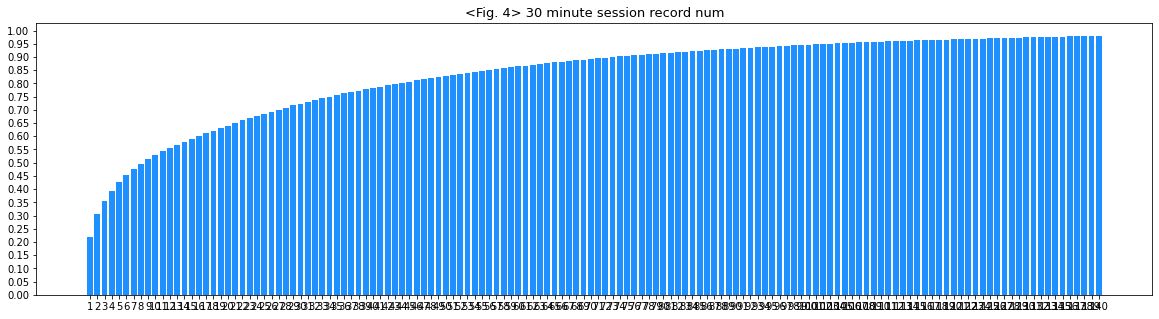

In [19]:
session_length = session_30min_data.groupby("Session").size()

print("*" * 35)
print(session_length.describe())
print("*" * 35)
print("98% session length", session_length.quantile(0.98))

#세션 길이에 따른 분포
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_98 = length_percent_cumsum[length_percent_cumsum < 0.98]


#시각화
plt.figure(figsize=(20, 5))
plt.title('<Fig. 4> 30 minute session record num', size=13)
plt.bar(x=length_percent_cumsum_98.index,
        height=length_percent_cumsum_98, color="#1e90ff")
plt.xticks(length_percent_cumsum_98.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.show()

<br>

#### 세션 시간 중심 분석
***
+ 영화에 대한 평가는 2000년 4월 25일부터 2003년 2월 28일 약 3년 동안 이루어 졌습니다.


+ 2003년 2월 28일 기준 약 1개월 이전의 데이터는 총 1,551개, 6개월 이전 데이터는 8,823개, 1년 이전 데이터는 21,704개, 2년 이전 데이터는 69,349개 입니다.
***

In [20]:
oldest, latest = session_30min_data['Time'].min(), session_30min_data['Time'].max()

month1 = len(session_30min_data[session_30min_data["Time"] > (latest - 30 * 1 * 86400)])
month6 = len(session_30min_data[session_30min_data["Time"] > (latest - 30 * 6 * 86400)])
month12 = len(session_30min_data[session_30min_data["Time"] > (latest - 365 * 1 * 86400)])
month24 = len(session_30min_data[session_30min_data["Time"] > (latest - 365 * 2 * 86400)])


print("data date:", datetime.fromtimestamp(oldest), "~", datetime.fromtimestamp(latest))
print("*" * 35)
print("1 month ago data num:", month1)
print("6 month ago data num:", month6)
print("12 month ago data num:", month12)
print("24 month ago data num:", month24)
print("*" * 35)

data date: 2000-04-25 23:05:32 ~ 2003-02-28 17:49:50
***********************************
1 month ago data num: 1551
6 month ago data num: 8823
12 month ago data num: 21704
24 month ago data num: 69349
***********************************


<br>

### 4.3. 1시간 단위 세션 데이터 분석
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 1시간 단위로 정의된 고유 세션은 총 31,969개 이며, 세션별 평균 약 31개의 레코드를 가지고 있습니다. 최대 711개의 레코드를 가진 세션이 존재하며, 75%의 세션은 38개의 레코드를, 98%의 세션은 199개의 레코드를 가지고 있습니다. 또한, 2003년 2월 28일 기준 약 1개월 이전의 데이터는 총 1,551개, 6개월 이전 데이터는 8,823개, 1년 이전 데이터는 21,704개, 2년 이전 데이터는 69,349개 입니다. &lt;Fig. 5>은 1시간 단위로 정의된 세션이 가지는 레코드 수에 따른 누적 비율을 시각화 한 것입니다.
</span>

***

#### 세션 길이 중심 분석
***
+ 총 31,969개의 세션이 존재하며, 세션별 평균 약 31개의 레코드를 가지고 있고 75%의 세션이 38개의 레코드를, 최대 711개의 레코드를 가지고 있는 세션이 존재 합니다.


+ 또한, 98%의 세션이 199개의 레코드를 가지고 있습니다.
***

***********************************
count   31969.000
mean       31.287
std        51.899
min         1.000
25%         2.000
50%         8.000
75%        38.000
max       711.000
dtype: float64
***********************************
98% session length 199.0


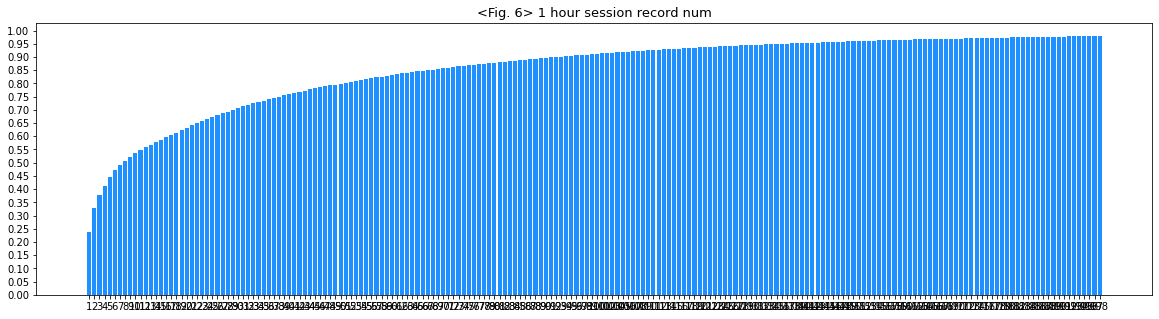

In [21]:
session_length = session_60min_data.groupby("Session").size()

print("*" * 35)
print(session_length.describe())
print("*" * 35)
print("98% session length", session_length.quantile(0.98))

#세션 길이에 따른 분포
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_98 = length_percent_cumsum[length_percent_cumsum < 0.98]


#시각화
plt.figure(figsize=(20, 5))
plt.title('<Fig. 6> 1 hour session record num', size=13)
plt.bar(x=length_percent_cumsum_98.index,
        height=length_percent_cumsum_98, color="#1e90ff")
plt.xticks(length_percent_cumsum_98.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.show()

<br>

#### 세션 시간 중심 분석
***
+ 영화에 대한 평가는 2000년 4월 25일부터 2003년 2월 28일 약 3년 동안 이루어 졌습니다.


+ 2003년 2월 28일 기준 약 1개월 이전의 데이터는 총 1,551개, 6개월 이전 데이터는 8,823개, 1년 이전 데이터는 21,704개, 2년 이전 데이터는 69,349개 입니다.
***

In [22]:
oldest, latest = session_60min_data['Time'].min(), session_60min_data['Time'].max()

month1 = len(session_60min_data[session_60min_data["Time"] > (latest - 30 * 1 * 86400)])
month6 = len(session_60min_data[session_60min_data["Time"] > (latest - 30 * 6 * 86400)])
month12 = len(session_60min_data[session_60min_data["Time"] > (latest - 365 * 1 * 86400)])
month24 = len(session_60min_data[session_60min_data["Time"] > (latest - 365 * 2 * 86400)])


print("data date:", datetime.fromtimestamp(oldest), "~", datetime.fromtimestamp(latest))
print("*" * 35)
print("1 month ago data num:", month1)
print("6 month ago data num:", month6)
print("12 month ago data num:", month12)
print("24 month ago data num:", month24)
print("*" * 35)

data date: 2000-04-25 23:05:32 ~ 2003-02-28 17:49:50
***********************************
1 month ago data num: 1551
6 month ago data num: 8823
12 month ago data num: 21704
24 month ago data num: 69349
***********************************


<br>

## 5. 데이터 전처리
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 앞서 진행한 데이터 분석과 세션 중심 데이터 분석을 토대로 데이터를 전처리 합니다. 데이터 전처리는 '세션 길이 중심 전처리', '세션 시간 중심 전처리', '평점 중심 전처리', '데이터 분할', '데이터 인덱싱' 순으로 진행합니다. '세션 길이 중심 전처리'에서는 1분 단위 세션의 경우 98%의 세션에 속하지 않는 12개 이상의 레코드를 가지고 있는 세션을 제거하고 30분 단위 세션의 경우 98%의 세션에 속하지 않는 142개 이상의 레코드를 가지고 있는 세션을 제거, 1시간 단위 세션의 경우에도 199개 이상의 레코드를 가지고 있는 세션을 이상치로 판단하여 제거합니다. '세션 시간 중심 전처리'에서는 '영화의  트랜드'를 고려하여 최근 2년 간의 데이터만을 추출 합니다. '평점 중심 전처리'에서는 평점 3점 미만의 데이터는 추천하지 않는 것으로 판단하고 제외 합니다. '데이터 분할' 단계에서는 최근 데이터 순으로 테스트 데이터, 검증 데이터, 학습 데이터를 추출하며, 테스트 데이터, 검증 데이터는 학습 데이터의 0.2 비율로 분할 합니다.
</span>

***

#### 세션 길이 중심 전처리
***
+ '1분 단위 세션'의 경우 98%에 속하지 않는 12개 이상의 레코드를 가지고 있는 세션은 이상치로 보고 제외 합니다.


+ '30분 단위 세션'의 경우 98%에 속하지 않는 142개 이상의 레코드를 가지고 있는 세션은 이상치로 보고 제외 합니다.


+ '1시간 단위 세션'의 경우 98%에 속하지 않는 199개 이상의 레코드를 가지고 있는 세션은 이상치로 보고 제외 합니다.
***

In [23]:
def cut_record(df, record_num):
    df = df.copy()
    size = df.groupby("Session").size().reset_index()
    df = pd.merge(df, size, on=["Session"])
    df = df[df[0] <= record_num]
    df.drop(columns=[0], inplace=True)
    return df


session_1min_data = cut_record(session_1min_data, 11)
session_30min_data = cut_record(session_30min_data, 141)
session_60min_data = cut_record(session_60min_data, 198)

<br>

#### 세션 시간 중심 전처리
***
+ 1, 30, 60분으로 분리된 세션 데이터 중, 최근 2년 간의 데이터만 이용 합니다.
***

In [24]:
def cut_time(df, base_date):
    df = df.copy()
    base_date = df["Time"].max() - base_date
    df = df[df["Time"] >= base_date]
    return df


session_1min_data = cut_time(session_1min_data, 365 * 2 * 86400)
session_30min_data = cut_time(session_30min_data, 365 * 2 * 86400)
session_60min_data = cut_time(session_60min_data, 365 * 2 * 86400)

oldest, latest = session_1min_data['Time'].min(), session_1min_data['Time'].max()


print("*" * 50)
print("data date:", datetime.fromtimestamp(oldest), "~", datetime.fromtimestamp(latest))
print("*" * 50)

**************************************************
data date: 2001-02-28 19:06:53 ~ 2003-02-28 17:49:50
**************************************************


<br>

#### 평점 중심 전처리
***
+ 평점 3미만의 데이터는 추천하지 않는 것으로 판단하고 제외 하여 줍니다.
***

In [25]:
session_1min_data = session_1min_data[session_1min_data['Rating'] >= 3]
session_30min_data = session_30min_data[session_30min_data['Rating'] >= 3]
session_60min_data = session_60min_data[session_60min_data['Rating'] >= 3]

<br>

#### 데이터 분할
***
+ 학습, 검증, 테스트 데이터로 분할 합니다.


+ 2년 간의 데이터를 검증 데이터, 테스트 데이터 각각 20%로 추출 합니다.


+ 최근 데이터 순으로 테스트 데이터, 검증 데이터, 학습 데이터를 분할 하여 줍니다.
***

In [26]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('Session')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - (n_days * 86400)].index
    session_in_test = session_last_time[session_last_time >= final_time - (n_days * 86400)].index

    before_date = data[data['Session'].isin(session_in_train)]
    after_date = data[data['Session'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date


def get_integrated_data(df, split_rate):
    train, test = split_by_date(df, split_rate)
    train, validation = split_by_date(train, int(split_rate * 0.2))
    return (train, validation, test)



train_1min, val_1min, test_1min = get_integrated_data(session_1min_data, 146)
train_30min, val_30min, test_30min = get_integrated_data(session_30min_data, 146)
train_60min, val_60min, test_60min = get_integrated_data(session_60min_data, 146)


print("*" * 50)
print("train data shape:", train_1min.shape)
print("validation data shape:", val_1min.shape)
print("test data shape:", test_1min.shape)
print("*" * 50)

**************************************************
train data shape: (48592, 5)
validation data shape: (914, 5)
test data shape: (6037, 5)
**************************************************


<br>

#### 학습 데이터를 기준으로 인덱싱
***
+ 학습 데이터에 존재하지 않는 데이터가 검증 데이터와 학습 데이터에 있을 수 있기 때문에 학습 데이터를 기준으로 인덱싱 합니다.
***

In [27]:
def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df


def get_indexing_data(train, val, test):
    id2idx = {item_id : index for index, item_id in enumerate(train['ItemId'].unique())}
    train, val, test = indexing(train, id2idx), indexing(val, id2idx), indexing(test, id2idx)
    return (train, val, test)


train_1min, val_1min, test_1min = get_indexing_data(train_1min, val_1min, test_1min)
train_30min, val_30min, test_30min = get_indexing_data(train_30min, val_30min, test_30min)
train_60min, val_60min, test_60min = get_indexing_data(train_60min, val_60min, test_60min)

<br>

## 6. 모델 설계
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 추천 모델을 생성 합니다. 모델 생성에 앞서, Session-Parallel 미니배치를 먼저 구현합니다. 이후, RNN 모델을 생성하고 이를 평가하기 위한 평가지표와 하이퍼파라미터를 설정하여 줍니다.
</span>

***

<br>

### 6.1. Session-Paralle 미니배치 구축
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; Session-Parallel Mini-Batches를 통해 Session 종료까지 대기하지 아니하고 병렬적으로 연산을 수행합니다. 이를 위해 Session을 객체로 생성하고 이를 바탕으로 Session-Parallel 미니배치 생성 클래스를 만들어 줍니다.
</span>

***

#### 세션 데이터셋 생성
***
+ 세션 시작 인덱스와 새로 인덱싱한 세션 값을 얻습니다.
***

In [28]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['Session'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['Session'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('Session').size().cumsum()
        return offsets

<br>

#### Session-Parallel 미니배치 생성 클래스
***
+ 앞서 생성한 `SessionDataset`를 바탕으로 Session-Parallel 미니배치를 생성하는 클래스를 만듭니다.
***

In [29]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

<br>

### 6.2. 모델 생성
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp;  SESSION-BASED RECOMMENDATIONS WITH RECURRENT NEURAL NETWORKS(2016) 기반의 RNN 모델을 생성합니다. 임베딩 레이어를 사용하지 않으며, GRU 레이어 이후 Dropout 층을 추가한 단순한 구조 입니다. &lt;Fig. 7>은 모델을 시각화 한 것입니다. 또한, 모델을 평가하기 위한 평가지표를 설계하고 하이퍼파라미터를 설정하여 줍니다.
</span><br><br>

<img src="./img/model.png" width=400></img>

&lt;Fig. 7> Model architecture
***

#### 평가지표 설계
***
+ 앞서 생성한 `SessionDataset`를 바탕으로 Session-Parallel 미니배치를 생성하는 클래스를 만듭니다.
***

In [30]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

<br>

#### 하이퍼 파라미터 관리 클래스 생성
***
+ `epoch`, `batch size`와 같은 하이퍼 파라미터를 관리하는 클래스를 생성합니다.
***

In [31]:
class Args:
    def __init__(self, tr, val, test, batch_size=64, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20):
        self.tr, self.val, self.test = tr, val, test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['Session'].nunique()
        self.batch_size, self.drop_rate, self.lr = batch_size, drop_rate, lr
        self.hsz = hsz
        self.epochs = epochs
        self.k = k

args_1min = Args(train_1min, val_1min, test_1min)
args_30min = Args(train_30min, val_30min, test_30min)
args_60min = Args(train_60min, val_60min, test_60min)

<br>

#### 모델 생성 함수
***
+ 앞서 획득한 하이퍼 파라미터 클래스를 바탕으로 모델을 생성하는 함수를 만듭니다.
***

In [32]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    return model

sample_model = create_model(args_1min)
sample_model.summary()
sample_model = None

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(64, 1, 3149)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 50), (64, 50)]      480150    
_________________________________________________________________
dropout (Dropout)            (64, 50)                  0         
_________________________________________________________________
dense (Dense)                (64, 3149)                160599    
Total params: 640,749
Trainable params: 640,749
Non-trainable params: 0
_________________________________________________________________


<br>

## 7. 모델 학습 및 평가
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 앞서 정의한 세션별 데이터를 바탕으로 모델 학습과 평가를 진행합니다. 모든 모델은 64개의 배치사이즈와, 01 비율의 dropout과 0.001 학습률, 10 epoch로 학습을 진행합니다. 모델 평가는 최종적으로 테스트 데이터에 대한 모델의 Recall과 MRR 지표를 바탕으로 이루어집니다.
</span>

***

#### 학습 함수 생성
***
+ 모델 학습 및 평가 지표 출력 함수를 생성 합니다.
***

In [33]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)
    
    dic = {"val_recall": [], "val_mrr": []}

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['Session'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        dic["val_recall"].append(val_recall)
        dic["val_mrr"].append(val_mrr)
        
        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")
        
    return dic


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['Session'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr


def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

<br>

### 7.1. 1분 기준 세션 모델 학습
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 1분 기준 세션 모델의 학습 및 평가를 시행합니다. epoch는 총 10회 진행하였으며 테스트 데이터에 대한 모델의 성능은 Recall이 0.080, MRR이 0.023입니다. &lt;Fig. 8>은 1분 기준 세션 모델의 학습 과정에 대한 Recall과 MRR의 변화를 시각화 한 것입니다.
</span>

***

#### 학습 진행
***
+ 모델 학습을 진행합니다.
***

In [34]:
model_1min = create_model(args_1min)
history = train_model(model_1min, args_1min)

Train:   0%|          | 0/361 [00:00<?, ?it/s, accuracy=0, train_loss=7.34]     

	 - Recall@20 epoch 1: 0.058594
	 - MRR@20    epoch 1: 0.013935



Train:   0%|          | 0/361 [00:00<?, ?it/s, accuracy=0, train_loss=7.32]     

	 - Recall@20 epoch 2: 0.050781
	 - MRR@20    epoch 2: 0.011517



Train:   0%|          | 0/361 [00:00<?, ?it/s, accuracy=0, train_loss=7.13]     

	 - Recall@20 epoch 3: 0.054688
	 - MRR@20    epoch 3: 0.010640



Train:   0%|          | 0/361 [00:00<?, ?it/s, accuracy=0, train_loss=7.18]     

	 - Recall@20 epoch 4: 0.054688
	 - MRR@20    epoch 4: 0.009864



Train:   0%|          | 0/361 [00:00<?, ?it/s, accuracy=0, train_loss=7.13]     

	 - Recall@20 epoch 5: 0.058594
	 - MRR@20    epoch 5: 0.009298



Train:   0%|          | 0/361 [00:00<?, ?it/s, accuracy=0.0156, train_loss=7.07]

	 - Recall@20 epoch 6: 0.046875
	 - MRR@20    epoch 6: 0.011189



Train:   0%|          | 0/361 [00:00<?, ?it/s, accuracy=0.0156, train_loss=6.98]

	 - Recall@20 epoch 7: 0.054688
	 - MRR@20    epoch 7: 0.008767



Train:   0%|          | 0/361 [00:00<?, ?it/s, accuracy=0.0156, train_loss=6.88]

	 - Recall@20 epoch 8: 0.054688
	 - MRR@20    epoch 8: 0.008872



Train:   0%|          | 0/361 [00:00<?, ?it/s, accuracy=0.0156, train_loss=6.81]

	 - Recall@20 epoch 9: 0.062500
	 - MRR@20    epoch 9: 0.009924



Evaluation:  80%|████████  | 4/5 [00:01<00:00,  2.16it/s]

	 - Recall@20 epoch 10: 0.074219
	 - MRR@20    epoch 10: 0.016273



<br>

#### 학습 과정 시각화
***
+ 학습 과정 중의 `Recall`과 `MRR`을 시각화 합니다.
***

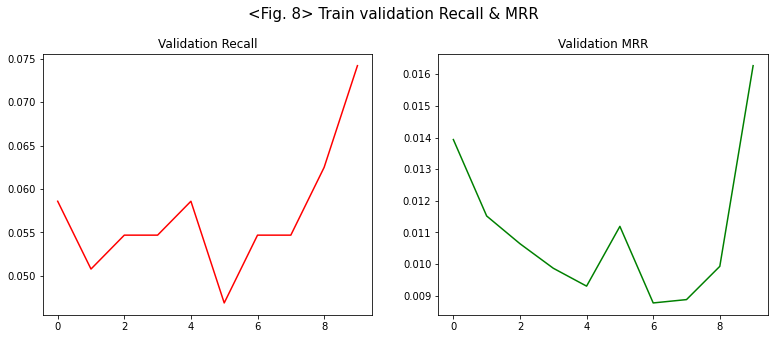

In [35]:
plt.figure(figsize=(13, 5))
plt.suptitle("<Fig. 8> Train validation Recall & MRR", fontsize=15)
plt.subplots_adjust(top=0.85)

plt.subplot(1, 2, 1)
plt.title("Validation Recall")
plt.plot(history["val_recall"], color="red")

plt.subplot(1, 2, 2)
plt.title("Validation MRR")
plt.plot(history["val_mrr"], color="green")
plt.show()

<br>

#### 모델 평가
***
+ 테스트 데이터에 대한 모델의 성능을 확인 합니다.
***

In [36]:
test_model(model_1min, args_1min, test_1min)

Evaluation:  98%|█████████▊| 41/42 [00:19<00:00,  2.15it/s]

	 - Recall@20: 0.080412
	 - MRR@20: 0.023488



<br>

### 7.2. 30분 기준 세션 모델 학습
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 30분 기준 세션 모델의 학습 및 평가를 시행합니다. epoch는 총 10회 진행하였으며 테스트 데이터에 대한 모델의 성능은 Recall이 0.099, MRR이 0.028입니다. &lt;Fig. 9>는 30분 기준 세션 모델의 학습 과정에 대한 Recall과 MRR의 변화를 시각화 한 것입니다.
</span>

***

#### 학습 진행
***
+ 모델 학습을 진행합니다.
***

In [37]:
model_30min = create_model(args_30min)
history = train_model(model_30min, args_30min)

Train:   0%|          | 0/626 [00:00<?, ?it/s, accuracy=0.0156, train_loss=7.57]

	 - Recall@20 epoch 1: 0.015625
	 - MRR@20    epoch 1: 0.002413



Train:   0%|          | 0/626 [00:00<?, ?it/s, accuracy=0.0156, train_loss=7.52]

	 - Recall@20 epoch 2: 0.007812
	 - MRR@20    epoch 2: 0.001953



Train:   0%|          | 0/626 [00:00<?, ?it/s, accuracy=0.0156, train_loss=7.44]

	 - Recall@20 epoch 3: 0.023438
	 - MRR@20    epoch 3: 0.002875



Train:   0%|          | 0/626 [00:00<?, ?it/s, accuracy=0, train_loss=7.14]     

	 - Recall@20 epoch 4: 0.015625
	 - MRR@20    epoch 4: 0.002441



Train:   0%|          | 0/626 [00:00<?, ?it/s, accuracy=0, train_loss=7.15]     

	 - Recall@20 epoch 5: 0.023438
	 - MRR@20    epoch 5: 0.001924



Train:   0%|          | 0/626 [00:00<?, ?it/s, accuracy=0, train_loss=6.93]     

	 - Recall@20 epoch 6: 0.031250
	 - MRR@20    epoch 6: 0.002171



Train:   0%|          | 0/626 [00:00<?, ?it/s, accuracy=0, train_loss=6.81]     

	 - Recall@20 epoch 7: 0.039062
	 - MRR@20    epoch 7: 0.003405



Train:   0%|          | 0/626 [00:00<?, ?it/s, accuracy=0.0156, train_loss=6.62]

	 - Recall@20 epoch 8: 0.023438
	 - MRR@20    epoch 8: 0.004427



Train:   0%|          | 0/626 [00:00<?, ?it/s, accuracy=0.0781, train_loss=6.54]

	 - Recall@20 epoch 9: 0.046875
	 - MRR@20    epoch 9: 0.006391



Evaluation:  18%|█▊        | 2/11 [00:00<00:04,  2.16it/s]

	 - Recall@20 epoch 10: 0.046875
	 - MRR@20    epoch 10: 0.010876



<br>

#### 학습 과정 시각화
***
+ 학습 과정 중의 `Recall`과 `MRR`을 시각화 합니다.
***

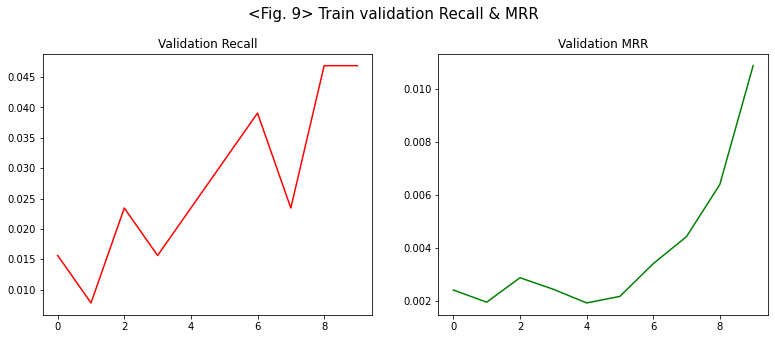

In [38]:
plt.figure(figsize=(13, 5))
plt.suptitle("<Fig. 9> Train validation Recall & MRR", fontsize=15)
plt.subplots_adjust(top=0.85)

plt.subplot(1, 2, 1)
plt.title("Validation Recall")
plt.plot(history["val_recall"], color="red")

plt.subplot(1, 2, 2)
plt.title("Validation MRR")
plt.plot(history["val_mrr"], color="green")
plt.show()

<br>

#### 모델 평가
***
+ 테스트 데이터에 대한 모델의 성능을 확인 합니다.
***

In [39]:
test_model(model_30min, args_30min, test_30min)

Evaluation:  79%|███████▊  | 59/75 [00:27<00:07,  2.17it/s]

	 - Recall@20: 0.099841
	 - MRR@20: 0.028946



<br>

### 7.2. 1시간 기준 세션 모델 학습
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 1시간 기준 세션 모델의 학습 및 평가를 시행합니다. epoch는 총 10회 진행하였으며 테스트 데이터에 대한 모델의 성능은 Recall이 0.092, MRR이 0.024입니다. &lt;Fig. 10>은 1시간 기준 세션 모델의 학습 과정에 대한 Recall과 MRR의 변화를 시각화 한 것입니다.
</span>

***

#### 학습 진행
***
+ 모델 학습을 진행합니다.
***

In [40]:
model_60min = create_model(args_60min)
history = train_model(model_60min, args_60min)

Train:   0%|          | 0/630 [00:00<?, ?it/s, accuracy=0, train_loss=7.59]     

	 - Recall@20 epoch 1: 0.015625
	 - MRR@20    epoch 1: 0.003906



Train:   0%|          | 0/630 [00:00<?, ?it/s, accuracy=0, train_loss=7.51]     

	 - Recall@20 epoch 2: 0.015625
	 - MRR@20    epoch 2: 0.003906



Train:   0%|          | 0/630 [00:00<?, ?it/s, accuracy=0, train_loss=7.41]     

	 - Recall@20 epoch 3: 0.015625
	 - MRR@20    epoch 3: 0.003906



Train:   0%|          | 0/630 [00:00<?, ?it/s, accuracy=0, train_loss=6.94]     

	 - Recall@20 epoch 4: 0.000000
	 - MRR@20    epoch 4: 0.000000



Train:   0%|          | 0/630 [00:00<?, ?it/s, accuracy=0, train_loss=7.11]     

	 - Recall@20 epoch 5: 0.000000
	 - MRR@20    epoch 5: 0.000000



Train:   0%|          | 0/630 [00:00<?, ?it/s, accuracy=0, train_loss=6.96]     

	 - Recall@20 epoch 6: 0.031250
	 - MRR@20    epoch 6: 0.001961



Train:   0%|          | 0/630 [00:00<?, ?it/s, accuracy=0.0156, train_loss=6.61]

	 - Recall@20 epoch 7: 0.031250
	 - MRR@20    epoch 7: 0.010937



Train:   0%|          | 0/630 [00:00<?, ?it/s, accuracy=0.0156, train_loss=6.72]

	 - Recall@20 epoch 8: 0.031250
	 - MRR@20    epoch 8: 0.005859



Train:   0%|          | 0/630 [00:00<?, ?it/s, accuracy=0.0156, train_loss=6.58]

	 - Recall@20 epoch 9: 0.031250
	 - MRR@20    epoch 9: 0.006127



Evaluation:   9%|▉         | 1/11 [00:00<00:04,  2.08it/s]

	 - Recall@20 epoch 10: 0.015625
	 - MRR@20    epoch 10: 0.007812



<br>

#### 학습 과정 시각화
***
+ 학습 과정 중의 `Recall`과 `MRR`을 시각화 합니다.
***

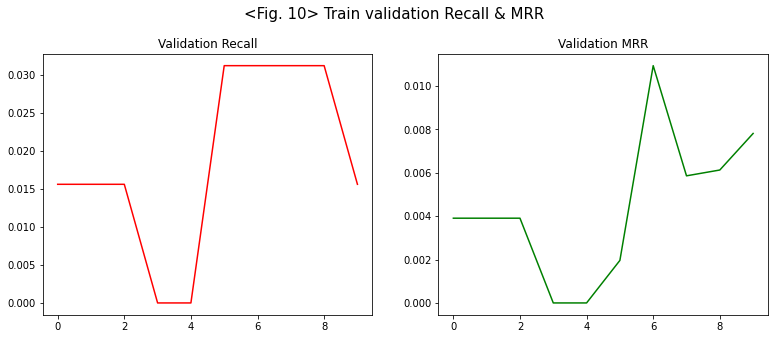

In [41]:
plt.figure(figsize=(13, 5))
plt.suptitle("<Fig. 10> Train validation Recall & MRR", fontsize=15)
plt.subplots_adjust(top=0.85)

plt.subplot(1, 2, 1)
plt.title("Validation Recall")
plt.plot(history["val_recall"], color="red")

plt.subplot(1, 2, 2)
plt.title("Validation MRR")
plt.plot(history["val_mrr"], color="green")
plt.show()

<br>

#### 모델 평가
***
+ 테스트 데이터에 대한 모델의 성능을 확인 합니다.
***

In [42]:
test_model(model_60min, args_60min, test_60min)

Evaluation:  75%|███████▍  | 56/75 [00:25<00:08,  2.19it/s]

	 - Recall@20: 0.092913
	 - MRR@20: 0.024357



<br>

## 8. 결론
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 'The MovieLens(2015)' 데이터셋을 이용하여 'UserId'와 'Time' 데이터를 바탕으로 세션 정의에 따른 추천 모델의 성능 변화를 살펴보았습니다. 1분, 30분, 1시간 단위로 구분하여 새롭게 정의하고 이를 바탕으로 RNN 추천 모델을 생성, 학습 하고 그 성능을 확인하였습니다.
그 결과 1분 기준 세션 모델은 Rcall이 0.080, MRR이 0.023이었으며, 30분 기준 세션 모델은 Rcall이 0.099, MRR이 0.029, 1시간 기준 세션 모델은 Rcall이 0.092, MRR이 0.024 입니다. 세션을 30분 기준으로 잡는 경우가 가장 성능이 좋았으며, 1시간으로 기준을 잡는 경우 Recall과 MRR이 감소하는 것을 바탕으로 오히려 성능이 감소하는 것을 확인하였습니다. 따라서, 'The MovieLens(2015)' 데이터셋에 한하여 세션을 30분 기준으로 설정하였을 때, 좋은 성능을 얻을 수 있다고 할 수 있습니다. 또한, 각 세션 모델을 올바르게 평가하기 위해 모든 하이퍼 파라미터를 동등하게 적용하였습니다. Epoch의 경우 평가를 위해 10회로 통일하여 학습을 진행하였지만, 학습을 더 진행하면 충분히 성능이 더 개선될 여지가 존재 합니다. [표 1]은 테스트 데이터에 대한 각 모델의 Recall과 MRR을 제시한 것입니다.
</span><br><br>


|Session|Recall|MRR|
|:--------:|:--------:|:--------:|
|**1 minute session**|0.080|0.023|
|**30 minute session**|**0.099**|**0.029**|
|**1 hour session**|0.092|0.024|

[표 1] 테스트 데이터에 대한 모델의 Recall 및 MRR

***

#### 형상관리 기록
***
+ v1_1: 실습 예제


+ v1_2: 데이터셋 이동


+ v2_1: 세션 정의 방법 도입


+ v3_1: 세션 정의 함수 도입
***